# Long Short Term Memory for Univariate Time Series Modelling

**Approach:** Create a sliding window out of the time series data to prepare the training and test data, and have the corresponding value in the target. Example: Use the stock price data from the last 60 days to make a prediction for the next 2 days. 

<img src="/images/lstm_notebook_introduction.png">

## Importing Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential 
from keras.layers import Dense 
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


## Importing Dataset

In [2]:
data = pd.read_csv('../datasets/Normal_Daily.csv')
print(data.head())
print(data.tail())

             STATION          STATION_NAME  ELEVATION  LATITUDE  LONGITUDE  \
0  GHCND:USC00327027  PETERSBURG 2 N ND US      466.3   48.0355     -98.01   
1  GHCND:USC00327027  PETERSBURG 2 N ND US      466.3   48.0355     -98.01   
2  GHCND:USC00327027  PETERSBURG 2 N ND US      466.3   48.0355     -98.01   
3  GHCND:USC00327027  PETERSBURG 2 N ND US      466.3   48.0355     -98.01   
4  GHCND:USC00327027  PETERSBURG 2 N ND US      466.3   48.0355     -98.01   

       DATE  DLY-TMIN-NORMAL  DLY-TMAX-NORMAL  MTD-PRCP-NORMAL  
0  20100101              -33              145                2  
1  20100102              -35              144                4  
2  20100103              -36              143                5  
3  20100104              -38              142                7  
4  20100105              -39              141                9  
               STATION          STATION_NAME  ELEVATION  LATITUDE  LONGITUDE  \
360  GHCND:USC00327027  PETERSBURG 2 N ND US      466.3   48.

In [3]:
date_col_name = 'DATE'

In [4]:
data[date_col_name] = pd.to_datetime(data[date_col_name], infer_datetime_format = True, unit = 'D', errors = 'ignore')

In [5]:
data = data.sort_values(by = date_col_name)

In [6]:
data.head()

STATION          STATION_NAME  ELEVATION  LATITUDE  LONGITUDE  \
0  GHCND:USC00327027  PETERSBURG 2 N ND US      466.3   48.0355     -98.01   
1  GHCND:USC00327027  PETERSBURG 2 N ND US      466.3   48.0355     -98.01   
2  GHCND:USC00327027  PETERSBURG 2 N ND US      466.3   48.0355     -98.01   
3  GHCND:USC00327027  PETERSBURG 2 N ND US      466.3   48.0355     -98.01   
4  GHCND:USC00327027  PETERSBURG 2 N ND US      466.3   48.0355     -98.01   

       DATE  DLY-TMIN-NORMAL  DLY-TMAX-NORMAL  MTD-PRCP-NORMAL  
0  20100101              -33              145                2  
1  20100102              -35              144                4  
2  20100103              -36              143                5  
3  20100104              -38              142                7  
4  20100105              -39              141                9

**Variable Description:**

* Test Length: The number of elements we want in our test set. In other words, a way to define our train-test split. 
* Target Length: The number of days we want our neural network to learn from at each step. In other words, number of columns in our training data. 
* Future Predictions: The number of days we want the neural network to predict for. 
* Target: The name of the column in the original dataset that we want to predict for. 

In [7]:
# Define all the variables

test_days = 30
target_history = 60
future_predictions = 1
target = 'DLY-TMAX-NORMAL'

In [8]:
if(type(data[target]) != int):
    pd.to_numeric(data[target])

<img src="/images/train-test.png">

<img src="/images/example.png">

## Doing a Train-Test Split

In [9]:
train_data = data[0:len(data)-test_days]
print(train_data.head())
print(train_data.tail())

             STATION          STATION_NAME  ELEVATION  LATITUDE  LONGITUDE  \
0  GHCND:USC00327027  PETERSBURG 2 N ND US      466.3   48.0355     -98.01   
1  GHCND:USC00327027  PETERSBURG 2 N ND US      466.3   48.0355     -98.01   
2  GHCND:USC00327027  PETERSBURG 2 N ND US      466.3   48.0355     -98.01   
3  GHCND:USC00327027  PETERSBURG 2 N ND US      466.3   48.0355     -98.01   
4  GHCND:USC00327027  PETERSBURG 2 N ND US      466.3   48.0355     -98.01   

       DATE  DLY-TMIN-NORMAL  DLY-TMAX-NORMAL  MTD-PRCP-NORMAL  
0  20100101              -33              145                2  
1  20100102              -35              144                4  
2  20100103              -36              143                5  
3  20100104              -38              142                7  
4  20100105              -39              141                9  
               STATION          STATION_NAME  ELEVATION  LATITUDE  LONGITUDE  \
330  GHCND:USC00327027  PETERSBURG 2 N ND US      466.3   48.

## Extracting the Relevant Univariate Time Series Column from the Data

In [10]:
loc = train_data.columns.get_loc(target)
train_column = train_data.iloc[:, loc:loc+1].values

## Scaling the Data

In [11]:
sc = MinMaxScaler()

scaled_train_column = sc.fit_transform(train_column)

/opt/conda/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


## Converting the 1-D Data Vector into 2-D Array and Corresponding Target Value

In [12]:
X_train = []
y_train = []

for i in range(target_history, len(scaled_train_column) - future_predictions):
    X_train.append(scaled_train_column[i-target_history:i, 0])
    y_train.append(scaled_train_column[i:i+future_predictions, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)

# Preparing the data for input into a Keras RNN Model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [13]:
print(X_train[0])
print(y_train[0])

[[0.01049475]
 [0.0089955 ]
 [0.00749625]
 [0.005997  ]
 [0.00449775]
 [0.0029985 ]
 [0.0029985 ]
 [0.00149925]
 [0.00149925]
 [0.00149925]
 [0.        ]
 [0.00149925]
 [0.00149925]
 [0.00149925]
 [0.0029985 ]
 [0.0029985 ]
 [0.00449775]
 [0.005997  ]
 [0.00749625]
 [0.0089955 ]
 [0.01049475]
 [0.011994  ]
 [0.0149925 ]
 [0.01649175]
 [0.01949025]
 [0.02098951]
 [0.02398801]
 [0.02698651]
 [0.02998501]
 [0.03298351]
 [0.03598201]
 [0.03898051]
 [0.04197901]
 [0.04647676]
 [0.04947526]
 [0.05247376]
 [0.05697151]
 [0.05997001]
 [0.06446777]
 [0.06746627]
 [0.07196402]
 [0.07496252]
 [0.07946027]
 [0.08395802]
 [0.08695652]
 [0.09145427]
 [0.09595202]
 [0.10044978]
 [0.10344828]
 [0.10794603]
 [0.11244378]
 [0.11694153]
 [0.12143928]
 [0.12743628]
 [0.13193403]
 [0.13643178]
 [0.14092954]
 [0.14692654]
 [0.15142429]
 [0.15742129]]
[0.16341829]


In [14]:
print(X_train.shape)
print(y_train.shape)

(274, 60, 1)
(274, 1)


## Looking at the Test Data

In [15]:
test_data = data[len(data)-test_days:]
print(test_data.head())
print(test_data.tail())

               STATION          STATION_NAME  ELEVATION  LATITUDE  LONGITUDE  \
335  GHCND:USC00327027  PETERSBURG 2 N ND US      466.3   48.0355     -98.01   
336  GHCND:USC00327027  PETERSBURG 2 N ND US      466.3   48.0355     -98.01   
337  GHCND:USC00327027  PETERSBURG 2 N ND US      466.3   48.0355     -98.01   
338  GHCND:USC00327027  PETERSBURG 2 N ND US      466.3   48.0355     -98.01   
339  GHCND:USC00327027  PETERSBURG 2 N ND US      466.3   48.0355     -98.01   

         DATE  DLY-TMIN-NORMAL  DLY-TMAX-NORMAL  MTD-PRCP-NORMAL  
335  20101202               73              239                5  
336  20101203               68              234                8  
337  20101204               63              230               11  
338  20101205               58              225               13  
339  20101206               53              221               16  
               STATION          STATION_NAME  ELEVATION  LATITUDE  LONGITUDE  \
360  GHCND:USC00327027  PETERSBURG 2 

## Appropriately Structuring the Test Data

* Creating an input_for_test_data Vector 
* Creating the Target Information Vector
* Rescaling the Remaining Data for Input into the 2-D Array Used as Test Input

In [16]:
data_column = data[target]

X_test = []
y_test = []

input_for_test_data = data_column[len(data_column) - len(test_data) - target_history:].values
input_for_test_data = input_for_test_data.reshape(-1, 1)

for i in range(target_history, len(input_for_test_data)-future_predictions):
    y_test.append(input_for_test_data[i:i+future_predictions, 0])
    
input_for_test_data = sc.transform(input_for_test_data)

for i in range(target_history, len(input_for_test_data)-future_predictions):
    X_test.append(input_for_test_data[i-target_history:i, 0])
    
X_test, y_test = np.array(X_test), np.array(y_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(X_test[0])
print(y_test[0])

[[0.69565217]
 [0.68815592]
 [0.68065967]
 [0.67316342]
 [0.66566717]
 [0.65817091]
 [0.65067466]
 [0.64317841]
 [0.63568216]
 [0.62668666]
 [0.6191904 ]
 [0.6101949 ]
 [0.60269865]
 [0.59370315]
 [0.58470765]
 [0.57571214]
 [0.56671664]
 [0.55922039]
 [0.54872564]
 [0.53973013]
 [0.53073463]
 [0.52173913]
 [0.51124438]
 [0.50224888]
 [0.49175412]
 [0.48275862]
 [0.47226387]
 [0.46326837]
 [0.45277361]
 [0.44227886]
 [0.43178411]
 [0.42128936]
 [0.41229385]
 [0.4017991 ]
 [0.39130435]
 [0.3808096 ]
 [0.37031484]
 [0.35982009]
 [0.34932534]
 [0.34032984]
 [0.32983508]
 [0.31934033]
 [0.30884558]
 [0.29985007]
 [0.28935532]
 [0.28035982]
 [0.26986507]
 [0.26086957]
 [0.25187406]
 [0.24287856]
 [0.23388306]
 [0.22488756]
 [0.21589205]
 [0.20689655]
 [0.1994003 ]
 [0.1904048 ]
 [0.18290855]
 [0.17391304]
 [0.16641679]
 [0.15892054]]
[239]


In [17]:
print(X_test.shape)
print(y_test.shape)

(29, 60, 1)
(29, 1)


## Creating the LSTM

<img src="/images/c_lstm_layers.png">

In [18]:
LSTMR = Sequential()

# Adding the first LSTM layer 
LSTMR.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))

# Adding the second LSTM layer 
LSTMR.add(LSTM(units = 100, return_sequences = True))

# Adding the third LSTM layer 
LSTMR.add(LSTM(units = 100, return_sequences = True))

# Adding the fourth LSTM layer 
LSTMR.add(LSTM(units = 100))

# Addding the output layer
LSTMR.add(Dense(units=future_predictions))

## Compiling the LSTM Neural Network (this can take awhile without GPUs)

In [19]:
LSTMR.compile(optimizer = 'adam', loss = 'mean_squared_error')
LSTMR.fit(X_train, y_train, epochs = 75, batch_size = 32, verbose = 0)

### Making Predictions and Evaluating Performance

In [20]:
y_pred = LSTMR.predict(X_test)
y_pred = sc.inverse_transform(y_pred)

In [21]:
sq_error = 0
total_values = 0

for i in range(len(y_test)):
    for j in range(len(y_test[i])):
        error = y_test[i][j] - y_pred[i][j]
        sq_error = sq_error + error**2
        total_values += 1
        
mean_squared_error = sq_error/total_values
print("RMSE is: ", (mean_squared_error)**0.5)

RMSE is:  9.525375003404745


### Visualizing Results for 1-Dimensional Predictions (Next Day Only)

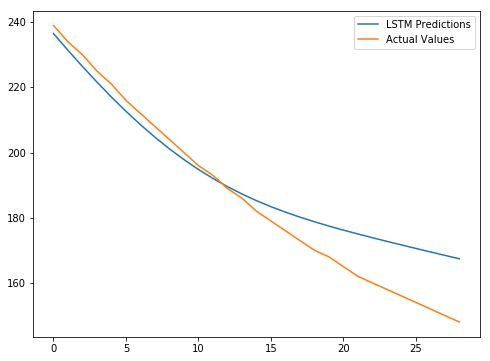

In [22]:
if future_predictions == 1:
    plt.figure(figsize = (8, 6))
    plt.plot(y_pred, label = 'LSTM Predictions')
    plt.plot(y_test, label = 'Actual Values')
    plt.legend()
    plt.show()  

### Developed by Data Science Elite Team, IBM Analytics:

* Aakanksha Joshi - Data Science and Machine Learning Intern (Summer 2018)

Copyright (c) 2018 IBM Corporation